In [1]:
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import xarray as xr
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/core/merge.py:18: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/core/dataarray.py:1829: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  'DataArray', pd.Series, pd.DataFrame, pd.Panel]:


## Parameters

In [2]:
use_clusters = [
    'CA3 Cadm2', 'CA1 Chrm3', 'CA3-St18 Tead1', 'Gfra1 Gfra1', 'IT-L5 Etv1',
    'CA1 Ptprg', 'NP-L6 Cntnap4', 'CA3-St18 Nuak1', 'CT-L6 Megf9',
    'IG-CA2 Chrm3', 'IG-CA2 Peak1', 'DG-po Calb2', 'DG dg-all', 'CA1 Kif26a',
    'CA3 Efnb2', 'CA1 Ak5', 'DG-po Bcl11a', 'PT-L5 Tenm2', 'CA1 Lingo2',
    'CA3-St18 Epha5', 'IG-CA2 Xpr1', 'DG-po Kctd8', 'CT-L6 Il1rap',
    'L6b Adcy8', 'IT-L6 Man1c1', 'NP-L6 Olfml2b', 'PT-L5 Abca12',
    'PT-L5 Nectin1', 'IT-L23 Cux1', 'IT-L23 Foxp1', 'IT-L4 Shc3', 'IT-L5 Cdh8',
    'IT-L5 Grik3', 'PT-L5 Tmtc2', 'IT-L23 Tenm2', 'NP-L6 Cntnap5a',
    'CT-L6 Hcrtr2', 'PT-L5 Plcb4', 'IT-L23 Ptprt', 'CT-L6 Map4', 'NP-L6 Boc',
    'PT-L5 Kcnh1', 'OLF-Exc Bmpr1b', 'PT-L5 Astn2', 'IT-L6 Fstl4',
    'CLA Bcl11a', 'NP-L6 Cyp7b1', 'CLA Cdh8', 'IT-L6 Cadps2', 'PT-L5 Ptprt',
    'NP-L6 Kcnab1', 'IT-L6 Oxr1', 'OLF-Exc Pld5', 'OLF-Exc Lrrtm3',
    'OLF-Exc Cdh9', 'OLF-Exc Unc13c', 'L6b Nrp2', 'OLF-Exc Sgcd',
    'OLF-Exc Rmst', 'PT-L5 Unc5b', 'L6b Pkhd1', 'L6b Kcnk2', 'IT-L4 Astn2',
    'CLA Nrp2', 'EP Tspan5', 'OLF-Exc Cux2', 'EP Rgs8', 'EP Adcy8'
]
n_comps = 30
method='average'
metric= 'correlation'# 'euclidean'

## Prepare Cluster Gene Level

In [ ]:
# mcds_pattern = \
# "/home/hanliu/project/mouse_rostral_brain/study/Level1-CellClass/ALL_manual/Adata/GeneWithSlop2kb.gene_da_rate.*.mcds"
# gene_mcds = xr.open_mfdataset(mcds_pattern)
# cell_meta = pd.read_msgpack(
#     '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
# )
# gene_mcds = gene_mcds.sel(mc_type='CHN', cell=cell_meta.index)
# 
# cell_meta.index.name = 'cell'
# group = xr.DataArray(cell_meta['SubType'])
# cluster_mean = gene_mcds.groupby(group).mean(dim='cell')
# cluster_mean = cluster_mean['gene_da'].to_pandas()
# cluster_mean.to_msgpack('SubType.gene_mean_mch.msg')

In [ ]:
cluster_mean = pd.read_msgpack('/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/SubType.gene_mean_mch.msg')
use_clusters = [i.replace('_', ' ') for i in use_clusters]
related_dmg = pd.read_msgpack('RelatedDMG.msg')
use_genes = related_dmg['gene_id'].unique()

use_data = cluster_mean.loc[use_clusters, use_genes]
use_data.shape

## PCA

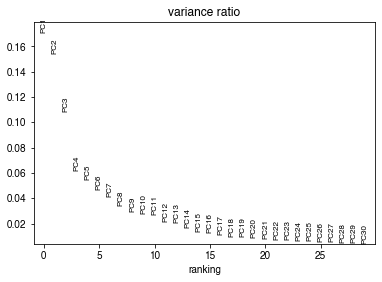

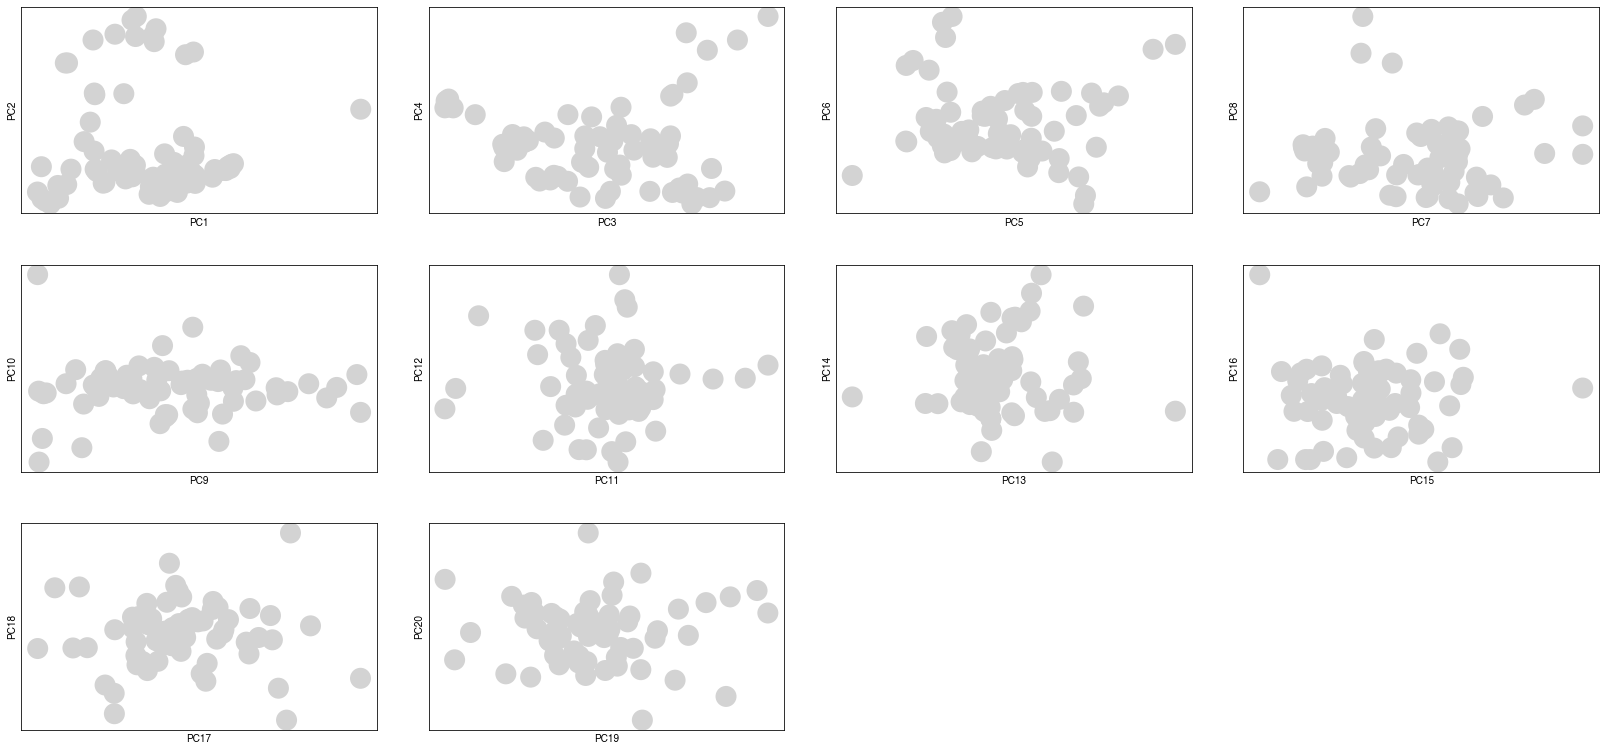

In [4]:
adata = anndata.AnnData(X=use_data.values,
                        obs=pd.DataFrame([], use_data.index),
                        var=pd.DataFrame([], use_data.columns))
sc.pp.scale(adata)
sc.pp.pca(adata, n_comps=30)
sc.pl.pca_variance_ratio(adata)
sc.pl.pca(adata,
          components=[
              '1,2', '3,4', '5,6', '7,8', '9,10', 
              '11,12', '13,14', '15,16', '17,18', '19,20', 
          ])

pc_df = pd.DataFrame(adata.obsm['X_pca'][:, :n_comps], 
                     index=adata.obs_names, 
                     columns=[f'PC{i}' for i in range(n_comps)])

## Generate dendrogram

In [5]:
# link = linkage(np.matrix(cluster_center.values), 
# method='average', metric='correlation', optimal_ordering=True)
link = linkage(np.matrix(pc_df.values), 
               method=method, metric=metric, optimal_ordering=True)

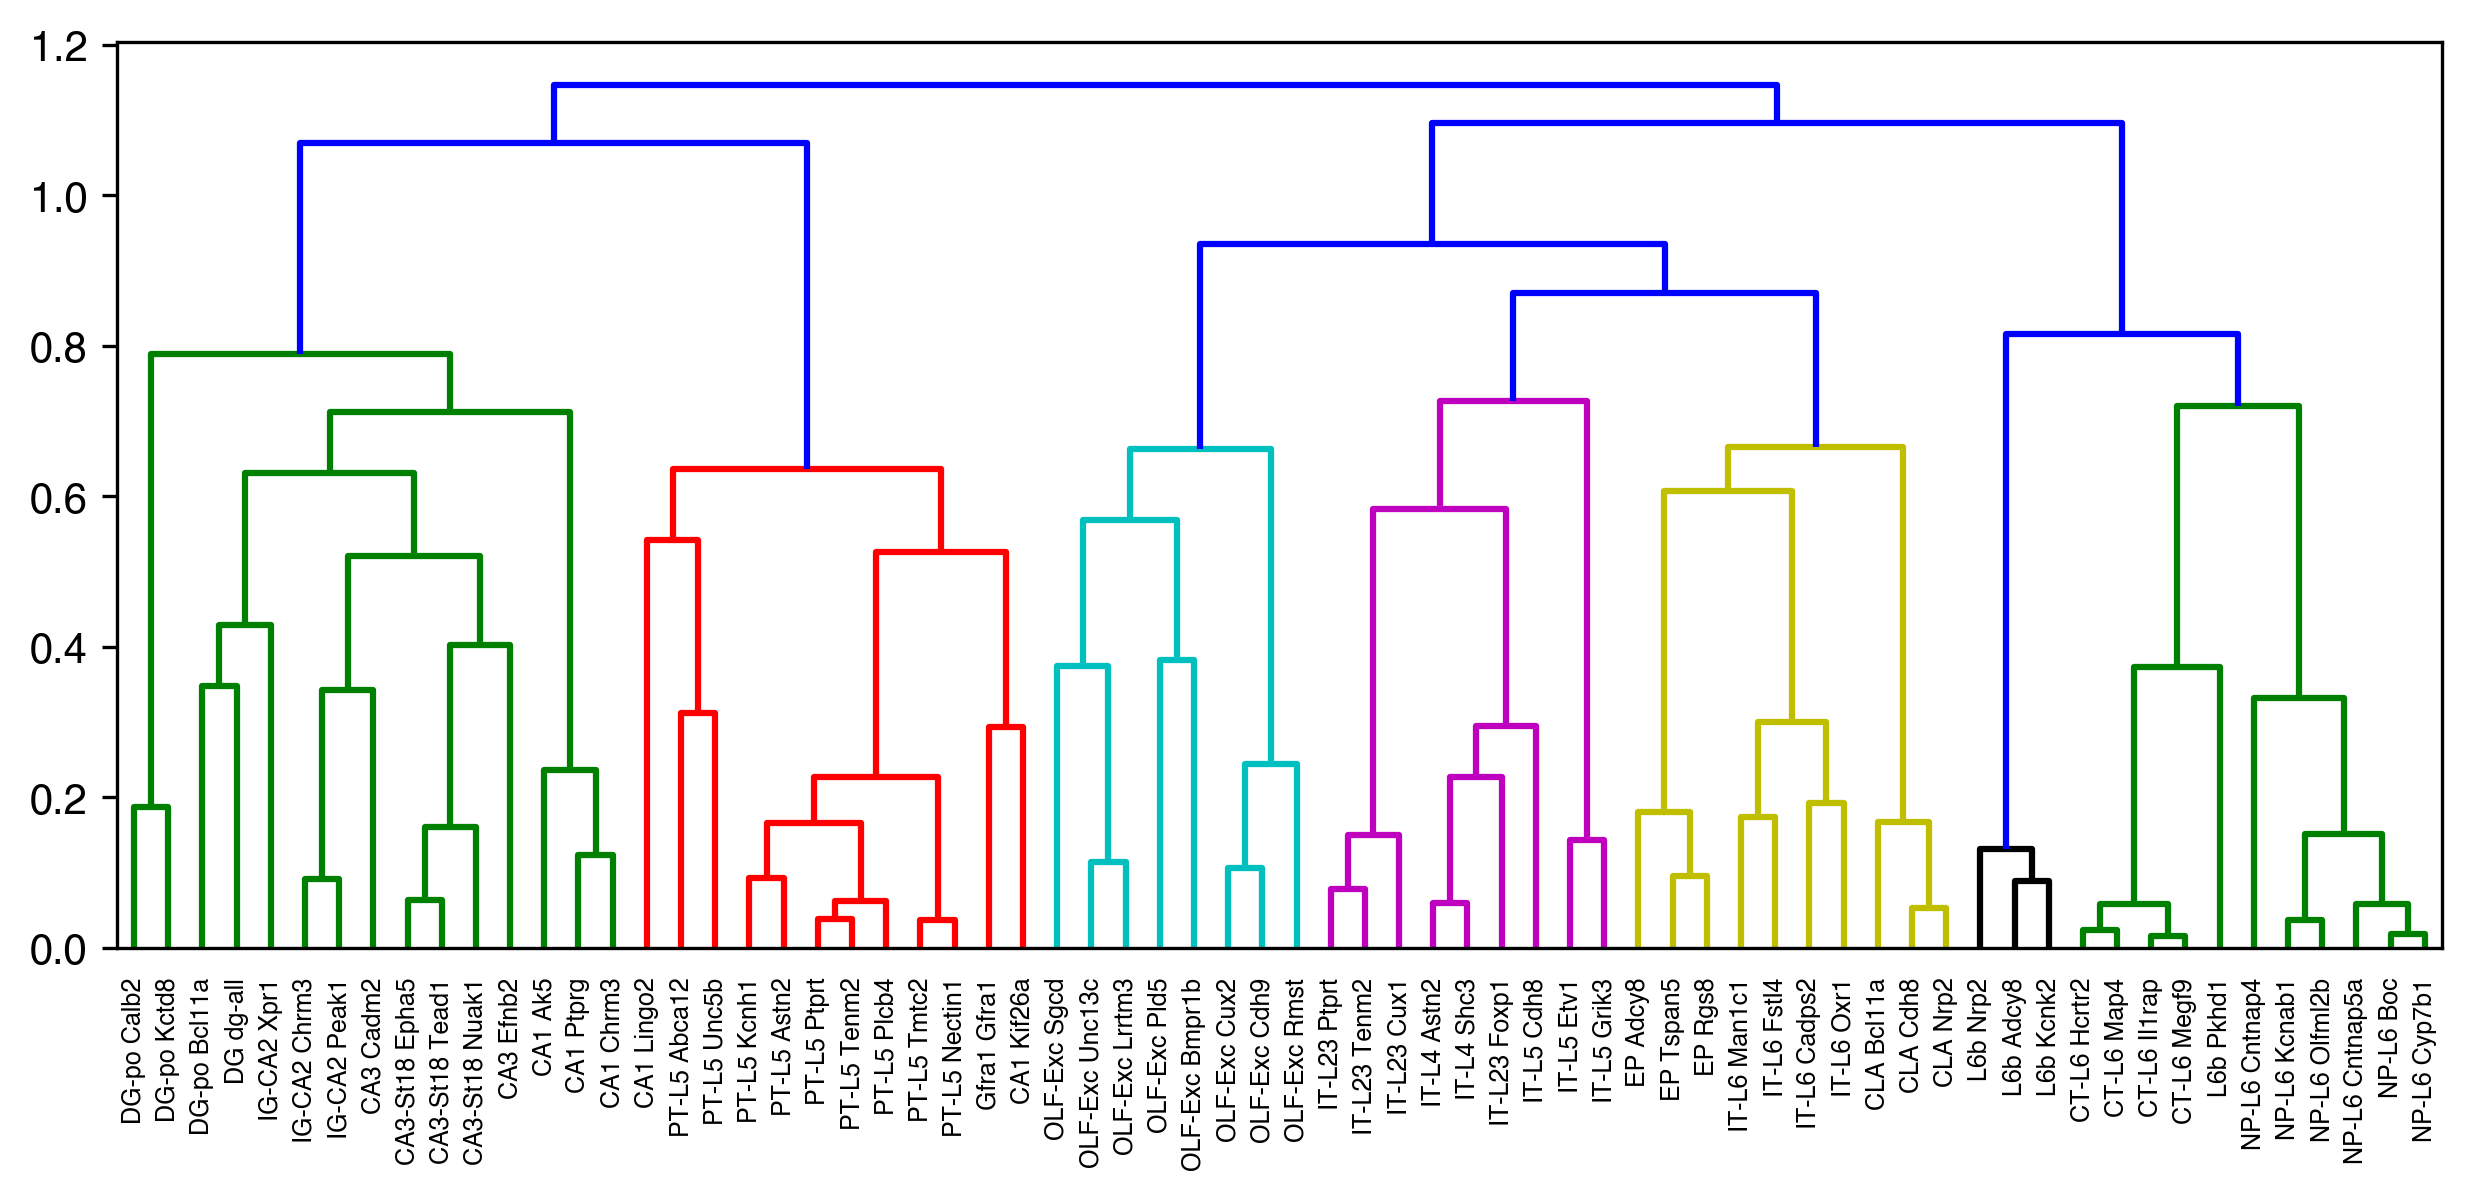

In [6]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
dendro = dendrogram(link, labels=pc_df.index, ax=ax)
ax.xaxis.set_tick_params(rotation=90)

## Save

In [7]:
import joblib
joblib.dump(dendro, 'Dendrogram.lib')
pd.DataFrame(link).to_csv('Linkage.csv', header=None, index=None)

from ALLCools.dmr.dendrogram import extract_all_nodes
non_singleton_node_dict = extract_all_nodes(link, labels=use_data.index)
joblib.dump(non_singleton_node_dict, 'non_singleton_node_dict.lib')

['non_singleton_node_dict.lib']